In [2]:
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
% matplotlib inline
import warnings

warnings.filterwarnings('ignore')

In [3]:
data_directory = Path('./data')

In [4]:
data_directory

WindowsPath('data')

In [28]:
data = pd.read_csv('C:/Users/luis3/PycharmProjects/LINKIT/ai_at_uni_ibm/hackaton/data/cardiotocography_train.csv')

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,130,10,54,1,34,2.1,0,3.0,0,0,...,50,182,8,0,159,151,155,25,1,1
1,120,4,23,5,36,1.5,0,13.5,0,0,...,62,174,6,0,119,129,125,42,0,1
2,133,0,0,4,20,2.7,0,18.5,6,0,...,63,161,7,0,136,124,134,61,1,1
3,136,4,0,5,46,0.8,1,7.4,0,0,...,119,158,1,1,144,143,145,1,0,1
4,130,6,557,6,29,1.7,0,7.8,5,0,...,65,177,6,1,133,129,133,27,0,1


In [29]:
print(data.shape[1] - 1, 'features and', data.shape[0], 'training examples')
data.head()

21 features and 1759 training examples


,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,130,10,54,1,34,2.1,0,3.0,0,0,...,50,182,8,0,159,151,155,25,1,1
1,120,4,23,5,36,1.5,0,13.5,0,0,...,62,174,6,0,119,129,125,42,0,1
2,133,0,0,4,20,2.7,0,18.5,6,0,...,63,161,7,0,136,124,134,61,1,1
3,136,4,0,5,46,0.8,1,7.4,0,0,...,119,158,1,1,144,143,145,1,0,1
4,130,6,557,6,29,1.7,0,7.8,5,0,...,65,177,6,1,133,129,133,27,0,1


In [30]:
data_test = pd.read_csv('C:/Users/luis3/PycharmProjects/LINKIT/ai_at_uni_ibm/hackaton/data/cardiotocography_test.csv')
print(data.shape[1] - 1, 'features and', data_test.shape[0], 'test examples')
data_test.head()

21 features and 367 test examples


,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,122,0,0,1,21,2.2,0,17.4,0,0,...,104,143,4,2,129,126,128,4,0,NaN
1,125,8,8,6,21,2.3,0,4.3,8,0,...,67,174,7,0,143,125,134,79,0,NaN
2,130,0,66,0,80,0.3,0,0.0,0,0,...,107,136,1,0,108,120,120,23,-1,NaN
3,125,0,1,8,62,1.7,0,1.1,7,0,...,68,140,5,0,130,116,125,29,1,NaN
4,145,0,1,1,34,1.7,0,25.9,0,0,...,57,166,5,1,150,147,150,10,1,NaN


<AxesSubplot:>

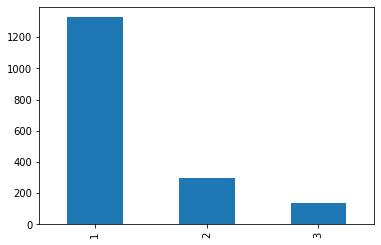

In [32]:
data["NSP"].value_counts().plot(kind="bar")

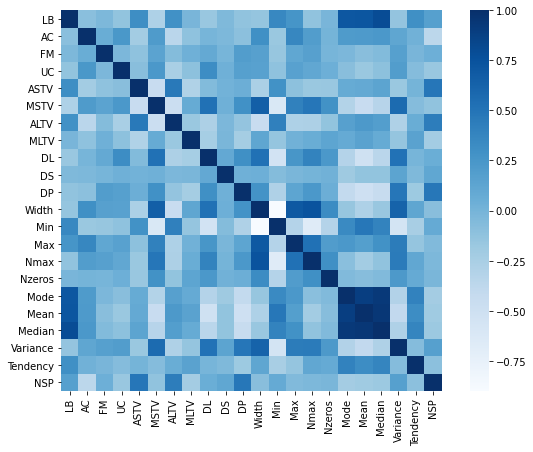

In [33]:
correlation_matrix = data.corr()
fig = plt.figure(figsize=(10, 7))
ax = plt.axes()
ax = sns.heatmap(correlation_matrix, mask=np.zeros_like(correlation_matrix, dtype=np.bool), cmap="Blues", square=True,
                 ax=ax)
plt.show()

In [34]:
data.isnull().sum()

LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
NSP         0
dtype: int64

In [36]:
data_test.isnull().sum()

array([1, 3, 2], dtype=int64)

In [37]:
data_onlySuspect = data.loc[data["NSP"] == 2]
data_onlySuspect.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
1464,120,0,0,0,73,0.5,43,2.4,0,0,...,62,126,2,0,120,137,121,73,1,2
1465,151,0,0,1,64,1.9,9,27.6,1,0,...,56,186,2,0,150,148,151,9,1,2
1466,150,0,0,1,64,2.0,8,29.5,1,0,...,56,186,5,0,150,148,151,10,1,2
1467,131,1,251,2,18,2.4,0,13.9,3,0,...,67,174,5,0,134,125,132,45,0,2
1468,132,0,162,1,29,4.4,0,10.5,10,0,...,50,191,7,1,133,119,129,73,0,2


In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [40]:
clf_nn = KNeighborsClassifier(n_neighbors=5)
clf_nn

KNeighborsClassifier()

In [42]:
X = data.drop(["NSP"], axis=1)
y = data["NSP"]

In [43]:
clf_nn.fit(X, y)

KNeighborsClassifier()

In [44]:
clf_nn.score(X, y)


0.923820352472996

In [ ]:
data_withoutSuspect = data.loc[data["NSP"] != 2]

<AxesSubplot:>

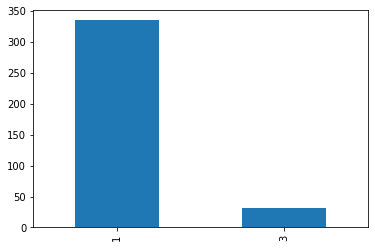

In [70]:
X_withoutSuspect = data_withoutSuspect.drop(["NSP"], axis=1)

y_withoutSuspect = data_withoutSuspect["NSP"]

clf_nn_wS = KNeighborsClassifier(n_neighbors=5)
clf_nn_wS
clf_nn_wS.fit(X_withoutSuspect, y_withoutSuspect)

clf_nn_wS.score(X_withoutSuspect, y_withoutSuspect)

final_model = clf_nn_wS.predict(data_test.drop(["NSP"], axis=1))
final_model
data_test_copy=data_test
data_test_copy["NSP"]=final_model
data_test_copy.head()
data_test_copy["NSP"].value_counts().plot(kind="bar")

In [72]:
data_test_copy.to_csv("Cape_Town.csv", sep=',', index=False)


